In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def gaussianpeak_testing():
    """ Test the Gaussian peak or dip estimator. """

    x_axis = np.linspace(0, 5, 50)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 4000*abs(np.random.normal(size=x_axis.shape))

    stepsize = abs(x_axis[1] - x_axis[0])
    n_steps = len(x_axis)


    # Smooth the provided data, so that noise fluctuations will
    # not disturb the parameter estimation.
    std_dev = 2
    data_smoothed = filters.gaussian_filter1d(data_noisy, std_dev)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='data')
    plt.plot(x_axis, data_smoothed, label='smoothed data')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # Define constraints
    # maximal and minimal the length of the given array to the right and to the
    # left:
    center_min = (x_axis[0]) - n_steps * stepsize
    center_max = (x_axis[-1]) + n_steps * stepsize
    ampl_min = 0
    sigma_min = stepsize
    sigma_max = 3 * (x_axis[-1] - x_axis[0])

    # set parameters
    offset = data_smoothed.min()
    params['offset'].set(value=offset)

    # it is more reliable to obtain select the maximal value rather then
    # calculating the first moment of the gaussian distribution (which is the
    # mean value), since it is unreliable if the distribution begins or ends at
    # the edges of the data:
    mean_val_calc =  np.sum(x_axis*(data_smoothed)) / np.sum(data_smoothed)
    center_val = x_axis[np.argmax(data_smoothed)]
    params['center'].set(value=center_val, min=center_min, max=center_max)

    # calculate the second moment of the gaussian distribution: int (x^2 * f(x) dx)
    mom2 = np.sum((x_axis)**2 * (data_smoothed)) / np.sum(data_smoothed)

    # and use the standard formula to obtain the standard deviation:
    #   sigma^2 = int( (x-mean)^2 f(x) dx ) = int (x^2 * f(x) dx) - mean^2

    print("mom2", mom2)
    print("std: ", np.sqrt(abs(mom2 - mean_val_calc**2)))

    # if the mean is situated at the edges of the distribution then this
    # procedure performs better then setting the initial value for sigma to
    # 1/3 of the length of the distibution since the calculated value for the
    # mean is then higher, which will decrease eventually the initial value for
    # sigma. But if the peak values is within the distribution the standard
    # deviation formula performs even better:
    params['sigma'].set(value=np.sqrt(abs(mom2 - mean_val_calc**2)), min=sigma_min, max=sigma_max)

    # do not set the maximal amplitude value based on the distribution, since
    # the fit will fail if the peak is at the edges or beyond the range of the
    # x values.
    params['amplitude'].set(value=data_smoothed.max() - data_smoothed.min(), min=ampl_min)

    result = mod_final.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis,result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis,result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

mom2 8.79519818679
std:  1.37145782693
[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 50
    # variables        = 4
    chi-square         = 309413030.638
    reduced chi-square = 6726370.231
    Akaike info crit   = 789.908
    Bayesian info crit = 797.556
[[Variables]]
    amplitude:   9942.29350 +/- 1.08e+03 (10.90%) (init= 11032.75)
    center:      3.03945192 +/- 0.084675 (2.79%) (init= 3.061224)
    sigma:       0.90277159 +/- 0.135990 (15.06%) (init= 1.371458)
    offset:      13485.4741 +/- 928.9350 (6.89%) (init= 12662.41)
    fwhm:        2.12586465 +/- 0.320233 (15.06%)  == '2.3548200450309493*sigma'
    contrast:    73.7259471 +/- 12.03524 (16.32%)  == '(amplitude/offset)*100'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, offset)             = -0.773 
    C(amplitude, offset)         = -0.668 
    C(amplitude, sigma)          =  0.24

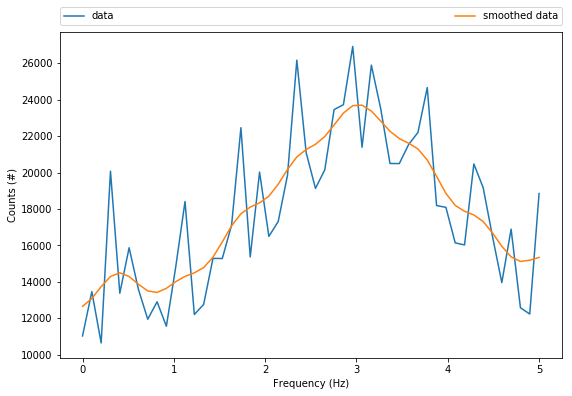

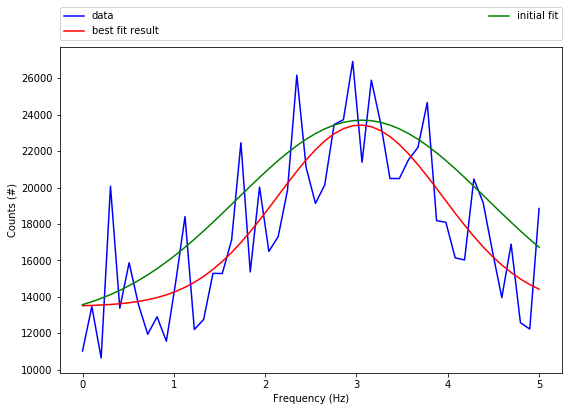

In [3]:
gaussianpeak_testing()

In [4]:
def gaussianpeak_testing2():
    """ Test the implemented Gaussian peak fit. """

    x_axis = np.linspace(0, 5, 11)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 2000*abs(np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussian_fit(x_axis=x_axis, data=data_noisy, estimator=fitlogic.estimate_gaussian_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 11
    # variables        = 4
    chi-square         = 2744620.321
    reduced chi-square = 392088.617
    Akaike info crit   = 144.700
    Bayesian info crit = 146.291
[[Variables]]
    amplitude:   10992.6151 +/- 619.4625 (5.64%) (init= 6580.483)
    center:      2.98579233 +/- 0.044721 (1.50%) (init= 3)
    sigma:       1.06945782 +/- 0.083309 (7.79%) (init= 1.501329)
    offset:      10136.2583 +/- 595.8374 (5.88%) (init= 11607.21)
    fwhm:        2.51838071 +/- 0.196179 (7.79%)  == '2.3548200450309493*sigma'
    contrast:    108.448451 +/- 11.73893 (10.82%)  == '(amplitude/offset)*100'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, offset)             = -0.835 
    C(amplitude, offset)         = -0.768 
    C(amplitude, sigma)          =  0.435 



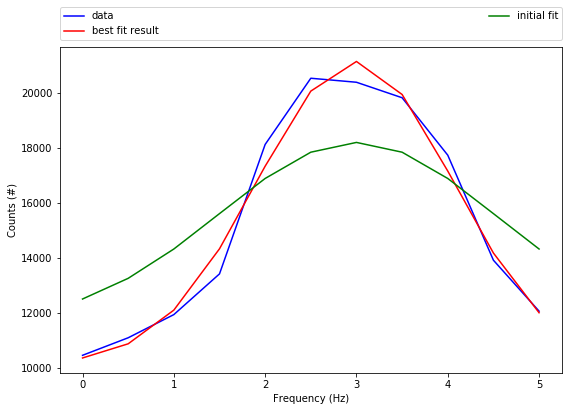

In [5]:
gaussianpeak_testing2()

In [6]:
def two_gaussian_peak_testing():
    """ Test the implemented estimator for two gaussian peaks with offset """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000+np.random.random(1)*50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000+np.random.random(1)*20000
    sigma1 = 25000+np.random.random(1)*20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0


    data_noisy=(mod.eval(x=x_axis,params=params) + 20000*np.random.normal(size=x_axis.shape))

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    threshold_fraction=0.4
    minimal_threshold=0.2
    sigma_threshold_fraction=0.3

    mod_lor, params_lor = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    error, params_lor = fitlogic.estimate_lorentziandouble_dip(
        x_axis=x_axis,
        data=-data_noisy,
        params=params_lor,
        threshold_fraction=threshold_fraction,
        minimal_threshold=minimal_threshold,
        sigma_threshold_fraction=sigma_threshold_fraction)

    result_lor = mod_lor.fit(-data_noisy, x=x_axis, params=params_lor)

    plt.figure()
    plt.plot(x_axis, -data_noisy, label="data")
    plt.plot(x_axis, result_lor.init_fit, label='init lorentz fit')
    plt.plot(x_axis, result_lor.best_fit, label='actual lorentz fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    params['g0_amplitude'].value = -params_lor['l0_amplitude'].value
    params['g0_center'].value = params_lor['l0_center'].value
    params['g0_sigma'].value = params_lor['l0_sigma'].value/(np.sqrt(2*np.log(2)))
    params['g1_amplitude'].value = -params_lor['l1_amplitude'].value
    params['g1_center'].value = params_lor['l1_center'].value
    params['g1_sigma'].value = params_lor['l1_sigma'].value/(np.sqrt(2*np.log(2)))
    params['offset'].value = -params_lor['offset'].value

    result = mod.fit(data_noisy, x=x_axis, params=params)
    print(result.fit_report())
    
    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

[[Model]]
    (((Model(amplitude_function, prefix='g0_') * Model(physical_gauss, prefix='g0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='g1_') * Model(physical_gauss, prefix='g1_')))
[[Fit Statistics]]
    # function evals   = 115
    # data points      = 200
    # variables        = 7
    chi-square         = 89787838960.416
    reduced chi-square = 465221963.525
    Akaike info crit   = 3998.480
    Bayesian info crit = 4021.568
[[Variables]]
    g0_amplitude:   1.3139e+05 +/- 5.38e+06 (4096.22%) (init= 231991)
    g0_center:      1.7997e+05 +/- 2.38e+05 (132.31%) (init= 160301.5)
    g0_sigma:       29419.8274 +/- 8.45e+04 (287.28%) (init= 20465.7)
    offset:        -355.871282 +/- 1.99e+03 (558.50%) (init= 8608.332)
    g1_amplitude:   1.3319e+05 +/- 4.27e+06 (3202.32%) (init= 222337.5)
    g1_center:      1.5178e+05 +/- 8.55e+05 (563.59%) (init= 166331.7)
    g1_sigma:       33679.5892 +/- 1.99e+05 (589.44%) (init= 21354.28)
    g0_fwhm:        69278.3994 

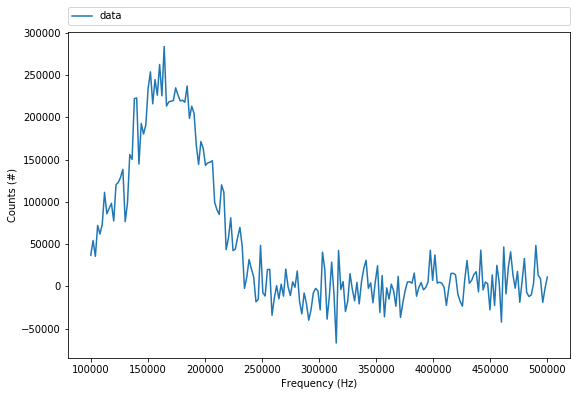

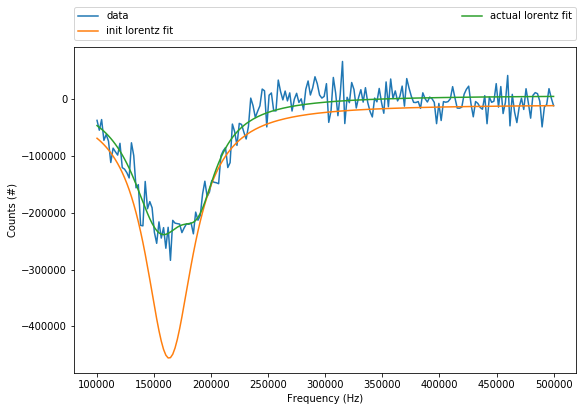

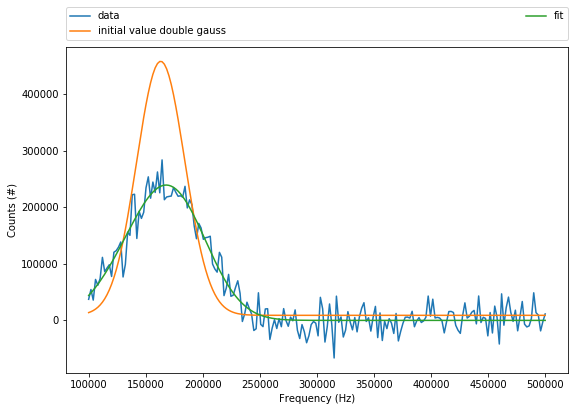

In [7]:
two_gaussian_peak_testing()

In [8]:
def two_gaussian_peak_testing2():
    """ Test the implemented Two Gaussian peak with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000 + np.random.random(1) * 20000
    sigma1 = 25000 + np.random.random(1) * 20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0

    data_noisy = (mod.eval(x=x_axis,params=params) + 20000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((Model(amplitude_function, prefix='g0_') * Model(physical_gauss, prefix='g0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='g1_') * Model(physical_gauss, prefix='g1_')))
[[Fit Statistics]]
    # function evals   = 88
    # data points      = 200
    # variables        = 7
    chi-square         = 77778577176.433
    reduced chi-square = 402997809.204
    Akaike info crit   = 3969.763
    Bayesian info crit = 3992.851
[[Variables]]
    g0_amplitude:   2.3477e+05 +/- 2.31e+04 (9.85%) (init= 132069)
    g0_center:      1.7117e+05 +/- 1.20e+03 (0.70%) (init= 166331.7)
    g0_sigma:       32016.7218 +/- 2.15e+03 (6.72%) (init= 42628.29)
    offset:        -3961.33895 +/- 4.00e+03 (100.86%) (init=-8140.66)
    g1_amplitude:   33629.5444 +/- 2.28e+04 (67.82%) (init= 132069)
    g1_center:      72869.5991 +/- 3.54e+05 (485.30%) (init= 166331.7)
    g1_sigma:       1.1974e+05 +/- 1.91e+05 (159.91%) (init= 42628.29)
    g0_fwhm:        75393.6183 +/- 5.07e+03

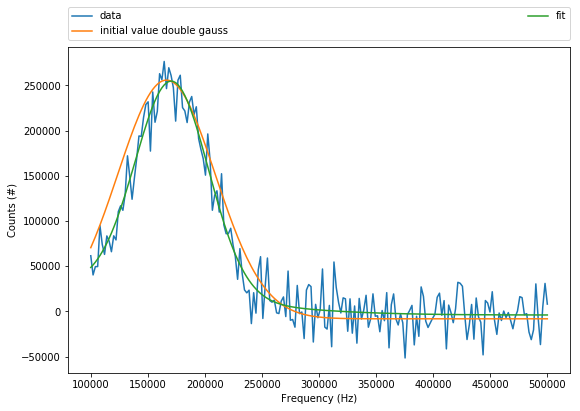

In [9]:
two_gaussian_peak_testing2()

In [10]:
def two_gaussian_dip_testing2():
    """ Test the implemented Two Gaussian dip with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = -75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1) * 200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 2500 + np.random.random(1) * 8000
    sigma1 = 2500 + np.random.random(1) * 8000
    splitting = 100000  # abs(np.random.random(1)*300000)
    offset = 200000

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = offset


    data_noisy=(mod.eval(x=x_axis,params=params) + 30000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_dip)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

[[Model]]
    (((Model(amplitude_function, prefix='g0_') * Model(physical_gauss, prefix='g0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='g1_') * Model(physical_gauss, prefix='g1_')))
[[Fit Statistics]]
    # function evals   = 320
    # data points      = 200
    # variables        = 7
    chi-square         = 162219173506.500
    reduced chi-square = 840513852.365
    Akaike info crit   = 4116.779
    Bayesian info crit = 4139.868
[[Variables]]
    g0_amplitude:  -18950.1699 +/- 6.20e+03 (32.74%) (init=-30813.93)
    g0_center:      3.6210e+05 +/- 1.55e+04 (4.27%) (init= 351256.3)
    g0_sigma:       44495.0563 +/- 1.86e+04 (41.78%) (init= 8617.923)
    offset:         2.0393e+05 +/- 3.23e+03 (1.58%) (init= 203045.6)
    g1_amplitude:  -43331.4720 +/- 1.82e+04 (41.93%) (init=-29620.47)
    g1_center:      4.6974e+05 +/- 2.11e+03 (0.45%) (init= 469849.2)
    g1_sigma:      -4386.89749 +/- 2.15e+03 (48.96%) (init= 8965.153)
    g0_fwhm:        1.0478e+05 +/- 4.38

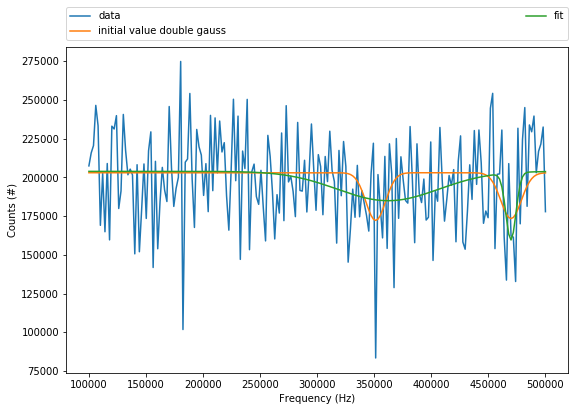

In [11]:
two_gaussian_dip_testing2()